In [1]:
import os, glob
import json
import pickle
from matplotlib import font_manager, rc
from module.module import * # 분석에 필요한 코드가 들어있는 모듈파일 import


plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

palette_1 = sns.color_palette('hls',8)
pd.set_option('display.max_columns', None)

path = os.path.join(os.getcwd(), "datas")

### 데이터 load 및 불필요한 변수제거
- vilemawkills, dominionvictoryscore, teamid : 분석에 필요없는 변수제거

In [9]:
with open('datas/teams_2.pkl', 'rb') as f:
    team_df = pickle.load(f)

In [10]:
team_df.drop(columns=['teamid', 'vilemawkills', 'dominionvictoryscore'], inplace=True)
team_df.tail(2)

,firstdragon,firstinhibitor,baronkills,firstriftherald,firstbaron,riftheraldkills,firstblood,firsttower,inhibitorkills,towerkills,win,dragonkills,gameduration
334586,False,True,0,False,False,0,False,False,1,6,Fail,1,2043
334587,True,False,2,True,True,2,True,True,2,10,Win,4,2043


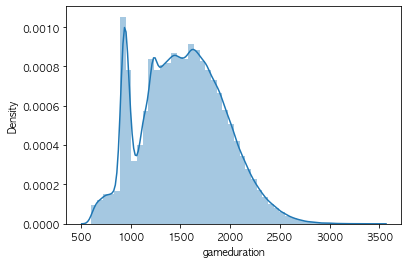

In [5]:
sns.distplot(team_df["gameduration"]);

- 조기서렌을 통해 15분에 끝난 게임의 비율이 가장 많고, 그 외 30분 내외에 게임이 많이 분포되어 있다.

### 플레이시간에 따른 오브젝트 중요도 시각화
- `20분 미만`, `20~30`, `30~40`, `40초과`로 세분화
- 판단지표
    - rate : (특정 오브젝트를 선점하고 이겼을 때의 팀 수 / 특정 오브젝트를 선점한 총 팀 수)

#### 기준에 따른 데이터셋 세분화

In [6]:
less20_df = team_df[team_df['gameduration'] < 1200].reset_index()
bet_2030_df = team_df[(team_df['gameduration'] >= 1200) & (team_df['gameduration'] < 1800)].reset_index()
bet_3040_df = team_df[(team_df['gameduration'] >= 1800) & (team_df['gameduration'] < 2400)].reset_index()
over40_df = team_df[team_df['gameduration'] >= 2400].reset_index()

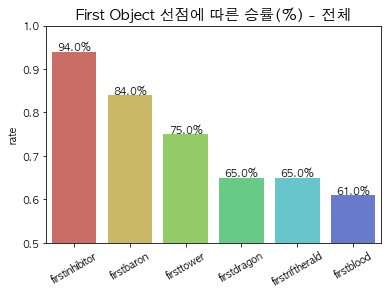

In [7]:
show_rateplot(team_df, "전체")

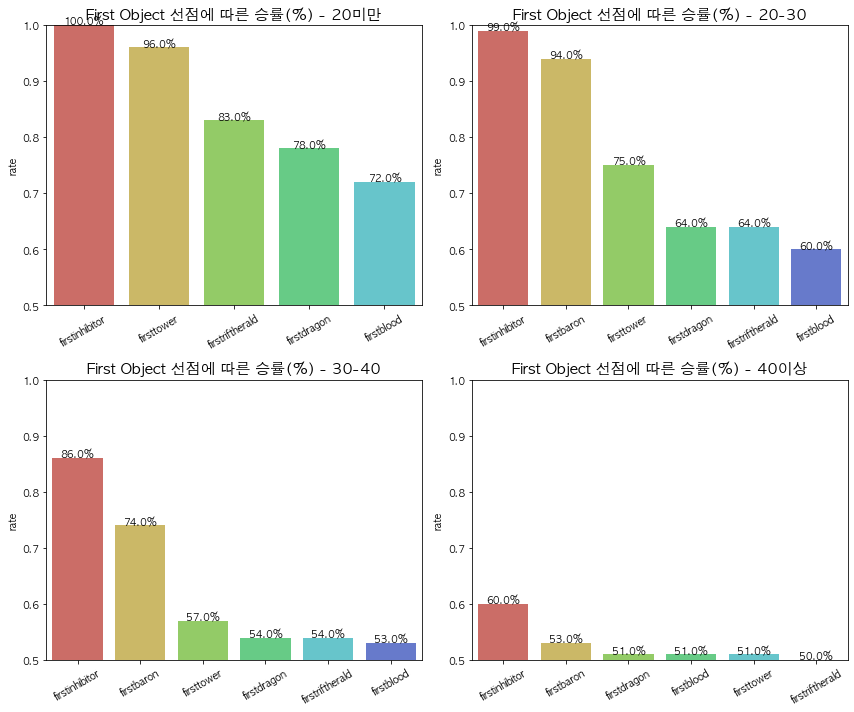

In [8]:
plt.figure(figsize=(12, 10))

plt.subplot(221)
show_rateplot(less20_df, "20미만")

plt.subplot(222)
show_rateplot(bet_2030_df, "20-30")

plt.subplot(223)
show_rateplot(bet_3040_df, "30-40")

plt.subplot(224)
show_rateplot(over40_df, "40이상")

plt.tight_layout()
plt.show()

- 20분 미만 : firstinhibitor(100%) > firsttower(96%) > firstriftherald(83%) > firstdragon(78%) > firstblood(72%)
- 20~30 : firstinhibitor(99%) > firstbaron(94%) > firsttower(75%) > firstdragon(64%) > firstriftherald(64%) > firstblood(60%)
- 30~40 : firstinhibitor(86%) > firstbaron(74%) > firsttower(57%) > firstdragon(54%) > firstriftherald(54%) > firstblood(53%)
- 40분 초과 : firstinhibitor(60%) > firstbaron(53%) > firstdragon(53%) > firstblood(51%) > firsttower(51%) > firstriftherald(50%)

### 특정 플레이시간 기준과 특정 오브젝트 선점에 가장 많이 개입한 포지션 및 해당 포지션의 TOP2 챔피언 추출
- 특정 플레이시간에서 특정 오브젝트 선점에 관여한 팀 데이터 중 승리한 데이터에서 각 포지션별 관여율 및 포지션마다 TOP2 픽률 챔피언 추출
- ex) 20분 미만의 firstinhibitor에 관여해서 이긴 팀 데이터의 각 포지션별 관여율 및 포지션별 TOP2 챔피언
    - 이긴 데이터의 정보를 제공함으로써 신뢰성을 높이고, 라인 및 챔피언을 추천하는 정보제공

#### 유저, 챔피언 정보 데이터셋 로드 및 데이터 전처리
- 필요한 변수 추출 및 결측데이터 처리

In [7]:
with open('datas/participants.pkl', 'rb') as f:
    participant_df = pickle.load(f)
    
with open('datas/participantextendedstats.pkl', 'rb') as f:
    participantextendedstat_df = pickle.load(f)
    
with open('datas/teams.pkl', 'rb') as f:
    team_df = pickle.load(f)

In [8]:
# 분석에 필요한 Columns만 추출 (첫 오브젝트 관여여부, 승리여부, 챔피언id)
participant_df['championid'] = participant_df['championid'].astype('str')

select_var = []
for col in participant_df.columns:
    if (participant_df[col].dtype == "O") and (col != "role"):
        select_var.append(col)
    elif col == "win":
        select_var.append(col)
    else:
        continue

select_var

['win',
 'firsttowerassist',
 'firsttowerkill',
 'firstbloodassist',
 'firstbloodkill',
 'championid',
 'firstinhibitorkill',
 'firstinhibitorassist']

In [9]:
participant_df = participant_df[select_var]
participant_df.tail(2)

,win,firsttowerassist,firsttowerkill,firstbloodassist,firstbloodkill,championid,firstinhibitorkill,firstinhibitorassist
1698278,True,False,False,False,True,86,False,False
1698279,True,False,False,False,False,555,False,False


#### 팀 데이터셋과 유저정보 데이터셋 병합
- participant_df : select_var
- participantextendedstat_df : position
- team_df : firstriftherald, firstbaron, gameduration

In [10]:
obj_posi_df = pd.concat([participant_df, participantextendedstat_df['position'], team_df[['firstriftherald', 'firstbaron', 'gameduration']]], axis=1)
obj_posi_df.tail(2)

,win,firsttowerassist,firsttowerkill,firstbloodassist,firstbloodkill,championid,firstinhibitorkill,firstinhibitorassist,position,firstriftherald,firstbaron,gameduration
1698278,True,False,False,False,True,86,False,False,MID,True,True,2043
1698279,True,False,False,False,False,555,False,False,SUPPORT,True,True,2043


#### 결측데이터 처리

- firstbloodkill, firstbloodassist : 조기서렌으로 무효처리된 게임이거나 조기서렌(15분) 전에 끝난 데이터
    - Max 플레이시간이 605초이므로 비정상 게임 데이터라고 판단하에 결측 데이터 제거
- firsttowerassist, firsttowerkill : 무효처리된 게임 데이터만 삭제
    - 나머지 결측 데이터는 조기서렌을 통한 게임이기에 정상데이터라고 판단 NaN -> False로 변환
- firstinhibitorkill, firstinhibitorassist
    - 결측 데이터는 조기서렌된 게임이기에 NaN -> False로 변환

In [11]:
obj_posi_df.isna().sum()

win                          0
firsttowerassist         21260
firsttowerkill           21260
firstbloodassist          4370
firstbloodkill            4370
championid                   0
firstinhibitorkill      398760
firstinhibitorassist    398760
position                     0
firstriftherald              0
firstbaron                   0
gameduration                 0
dtype: int64

In [12]:
obj_posi_df = preprocess_participant(obj_posi_df)

In [13]:
obj_posi_df.isna().sum()

win                0
championid         0
position           0
firstriftherald    0
firstbaron         0
gameduration       0
firstinhibitor     0
firsttower         0
firstblood         0
dtype: int64

#### 20~30에서, firstinhibitor관여하여 이긴 팀들의 포지션 비율 및 포지션 TOP2 챔피언 정보제공

In [14]:
recommendation_obj(obj_posi_df, 'firstinhibitor', 1200, 1800)

ADC의 firstinhibitor 기여도: 22.06%
ADC 중 TOP2 Champion: Ezreal(17.96%), Caitlyn(12.56%)
--------------
JUNGLE의 firstinhibitor 기여도: 19.57%
JUNGLE 중 TOP2 Champion: LeeSin(9.43%), Nidalee(8.6%)
--------------
MID의 firstinhibitor 기여도: 18.62%
MID 중 TOP2 Champion: Sylas(5.63%), Akali(5.54%)
--------------
SUPPORT의 firstinhibitor 기여도: 21.57%
SUPPORT 중 TOP2 Champion: Thresh(9.58%), Lulu(7.56%)
--------------
TOP의 firstinhibitor 기여도: 18.19%
TOP 중 TOP2 Champion: Camille(6.64%), Renekton(5.68%)
--------------


#### 20~30에서, firsttower에 관여하여 이긴 팀들의 포지션 비율 및 포지션 TOP2 챔피언 정보제공

In [17]:
recommendation_obj(obj_posi_df, 'firsttower', 1200, 1800)

ADC의 firsttower 기여도: 21.71%
ADC 중 TOP2 Champion: Caitlyn(16.74%), Ezreal(15.25%)
--------------
JUNGLE의 firsttower 기여도: 23.34%
JUNGLE 중 TOP2 Champion: LeeSin(9.77%), Graves(9.5%)
--------------
MID의 firsttower 기여도: 14.21%
MID 중 TOP2 Champion: Lucian(7.09%), Zed(5.3%)
--------------
SUPPORT의 firsttower 기여도: 17.5%
SUPPORT 중 TOP2 Champion: Thresh(9.33%), Lulu(7.74%)
--------------
TOP의 firsttower 기여도: 23.23%
TOP 중 TOP2 Champion: Renekton(8.12%), Camille(6.71%)
--------------


#### 20~30에서, firstbaron에 관여하여 이긴 팀들의 포지션 비율 및 포지션 TOP2 챔피언 정보제공

In [18]:
recommendation_obj(obj_posi_df, 'firstbaron', 1200, 1800)

ADC의 firstbaron 기여도: 20.0%
ADC 중 TOP2 Champion: Ezreal(17.18%), Caitlyn(12.13%)
--------------
JUNGLE의 firstbaron 기여도: 20.0%
JUNGLE 중 TOP2 Champion: LeeSin(9.09%), Graves(7.97%)
--------------
MID의 firstbaron 기여도: 20.0%
MID 중 TOP2 Champion: Akali(6.34%), Sylas(5.64%)
--------------
SUPPORT의 firstbaron 기여도: 20.0%
SUPPORT 중 TOP2 Champion: Thresh(9.6%), Lulu(6.7%)
--------------
TOP의 firstbaron 기여도: 20.0%
TOP 중 TOP2 Champion: Camille(7.26%), Renekton(5.74%)
--------------
